# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
<br>&emsp;- 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
<br>

2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
<br>&emsp;- 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
<br>

3. [Define Dataset Class](#Define-Dataset-Class)
<br>&emsp;- 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
<br>

4. [Check Data Sample](#Check-Data-Sample)
<br>&emsp;- 제공된 데이터가 어떤 모습인지 확인합니다.
<br>

5. [Setup Dataloader](#Setup-Dataloader)
<br>&emsp;- 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
<br>

6. [Define Functions for Training](#Define-Functions-for-Training)
<br>&emsp;- 학습을 도와주는 함수들을 정의합니다.
<br>

7. [Training](#Training)
<br>&emsp;- 학습을 진행합니다.
<br>

8. [Inference](#Inference)
<br>&emsp;- 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
<br>

9. [Result Visualization](#Result-Visualization)
<br>&emsp;- 인퍼런스 결과를 확인해봅니다.
<br>

10. [To CSV](#To-CSV)
<br>&emsp;- 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [242]:
import torchvision.transforms as tf
import torchvision.transforms.functional as fn
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torchvision

In [243]:
img = cv2.imread('/opt/ml/input/data/train/DCM/ID001/image1661130828152_R.png')
image = img.transpose(2, 0, 1)
image = torch.from_numpy(image)

In [244]:
tfimg = tf.Resize(1024)(image)
fnimg = fn.resize(image, 1024)
cvimg = cv2.resize(img, (1024, 1024))
aimg = A.Resize(512, 512)(image=img)

In [246]:
train_tf = A.Compose([A.HorizontalFlip(), A.GridDropout(ratio=0.1, random_offset=True, holes_number_x=4, holes_number_y=4), A.Rotate(limit=10, p=0.5)])

In [253]:
train_tf(iimg)

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

# AUG

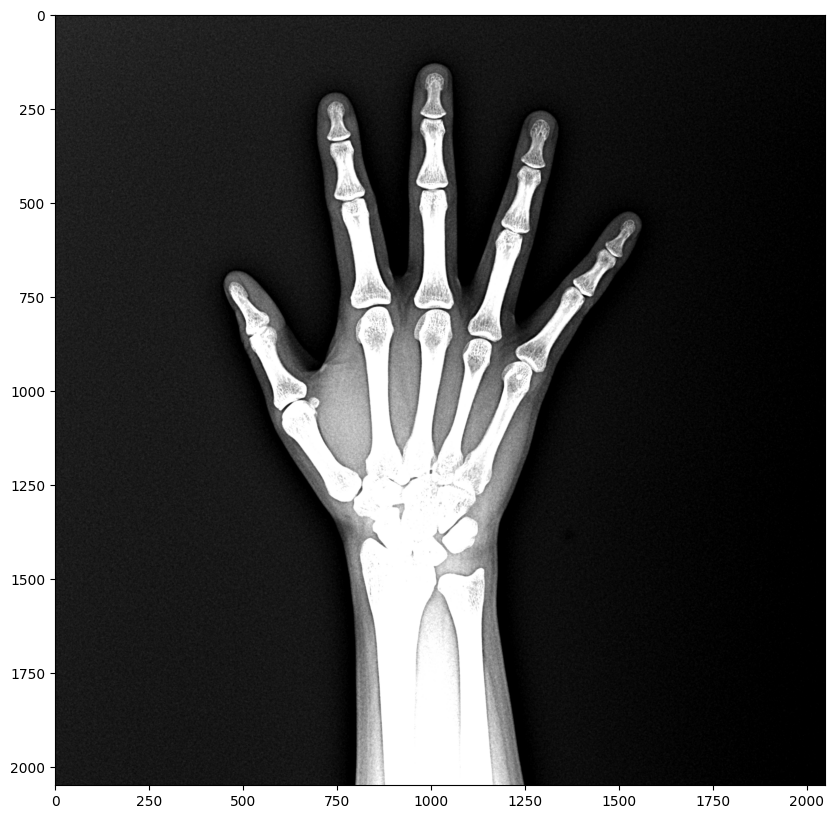

In [234]:
plt.figure(figsize=(10,10))
aug_img = fn.adjust_brightness(image, 2)
plt.imshow(aug_img.permute(1,2,0))

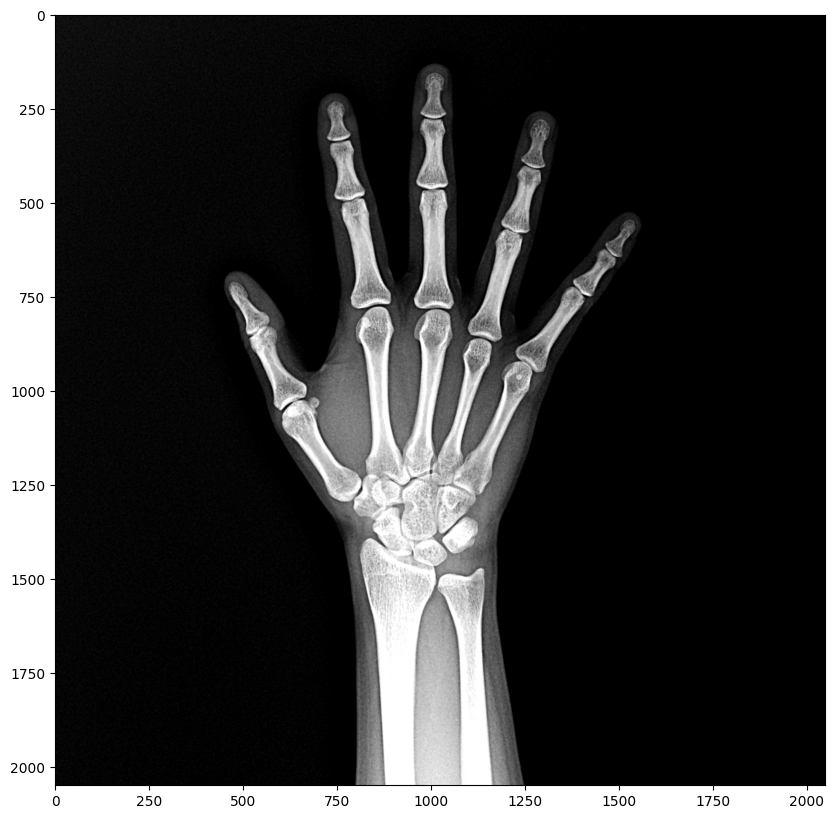

In [235]:
plt.figure(figsize=(10,10))
aug_img = fn.adjust_contrast(img=image, contrast_factor=1.5)
plt.imshow(aug_img.permute(1,2,0))

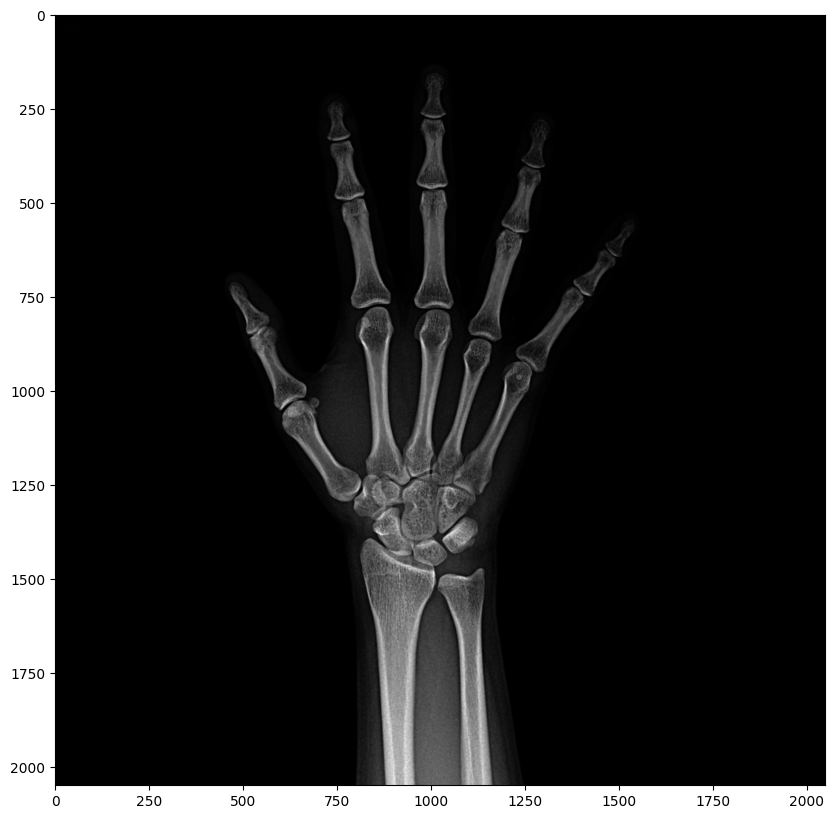

In [59]:
plt.figure(figsize=(10,10))
aug_img = fn.adjust_gamma(img=image, gamma=2)
plt.imshow(aug_img.permute(1,2,0))

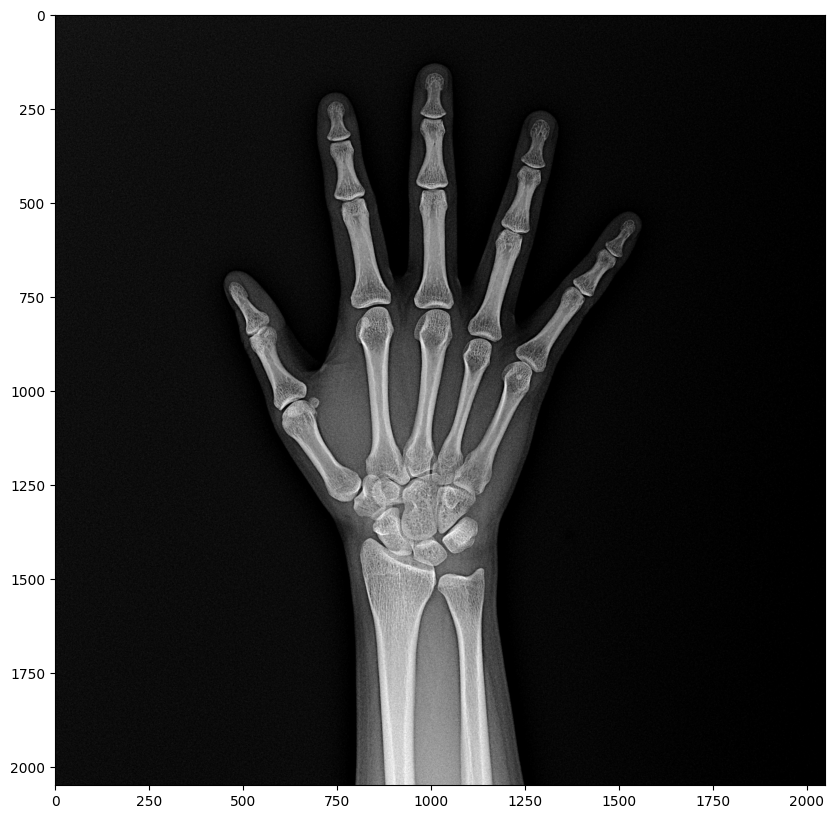

In [69]:
plt.figure(figsize=(10,10))
aug_img = fn.adjust_sharpness(img=image, sharpness_factor=5)
plt.imshow(aug_img.permute(1,2,0))

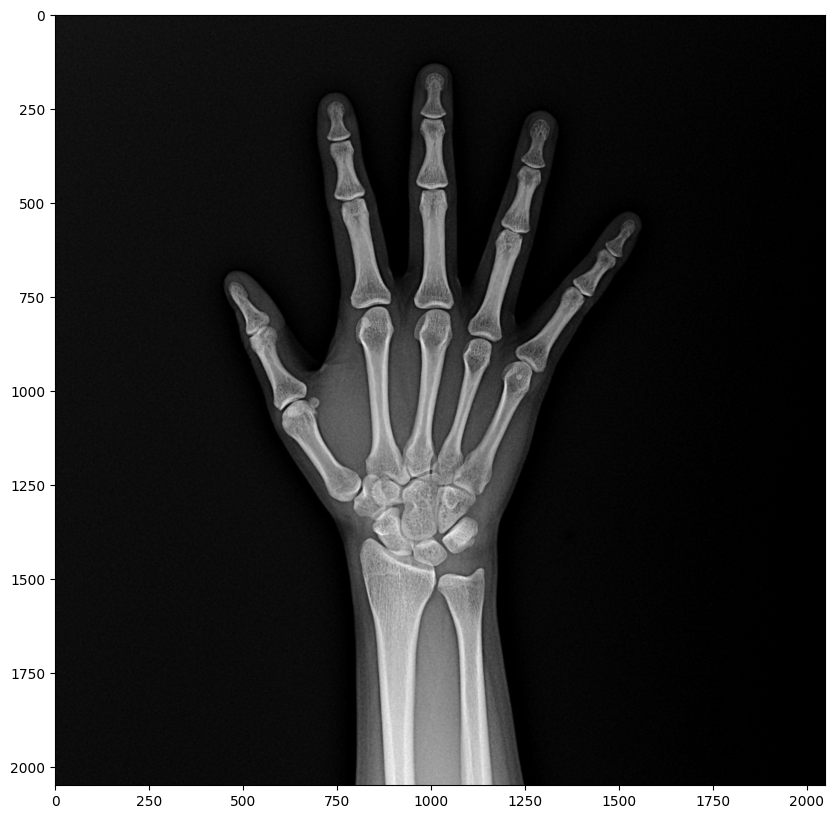

In [122]:
plt.figure(figsize=(10,10))
aug_img = fn.adjust_saturation(img=image, saturation_factor=2)
plt.imshow(aug_img.permute(1,2,0))

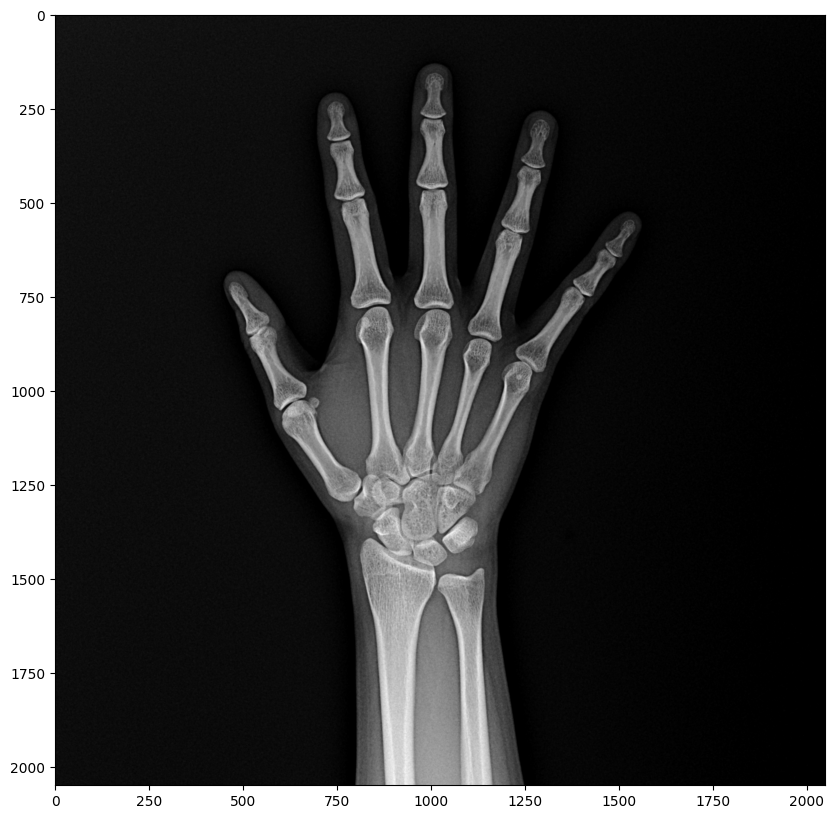

In [168]:
plt.figure(figsize=(10,10))
plt.imshow(image.permute(1,2,0))

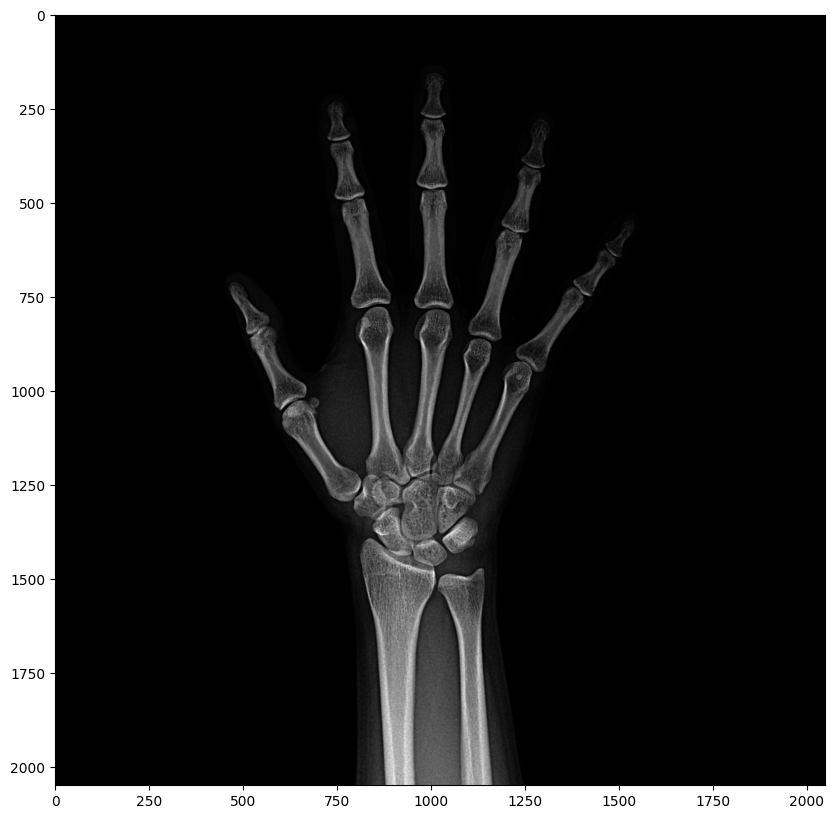

In [241]:
plt.figure(figsize=(10,10))

# aug_img = fn.adjust_brightness(image, 1.5)
aug_img = fn.adjust_sharpness(img=image, sharpness_factor=2)
aug_img = fn.adjust_contrast(img=aug_img, contrast_factor=1)
aug_img = fn.adjust_gamma(img=aug_img, gamma=2)
# aug_img = fn.adjust_contrast(img=aug_img, contrast_factor=1.5)
# aug_img = fn.adjust_sharpness(img=aug_img, sharpness_factor=10)
# aug_img = fn.adjust_gamma(img=aug_img, gamma=1.8)
# aug_img = fn.adjust_saturation(img=aug_img, saturation_factor=1)
plt.imshow(aug_img.permute(1,2,0))


In [142]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/train/DCM"
LABEL_ROOT = "/opt/ml/input/data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 8
LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 2    # CHANGE
VAL_EVERY = 1
SAVED_DIR = "./trained_model" 

if not os.path.isdir(SAVED_DIR):                                                           
    os.mkdir(SAVED_DIR)

In [16]:
model = torch.load('beit_base_patch16_224_pt22k_ft22k.pth')
model['model'].keys()

odict_keys(['cls_token', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.gamma_1', 'blocks.0.gamma_2', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.q_bias', 'blocks.0.attn.v_bias', 'blocks.0.attn.relative_position_bias_table', 'blocks.0.attn.relative_position_index', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.gamma_1', 'blocks.1.gamma_2', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.q_bias', 'blocks.1.attn.v_bias', 'blocks.1.attn.relative_position_bias_table', 'blocks.1.attn.relative_position_index', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'bloc

In [14]:
model = torch.load('beit_base_patch16_640_pt22k_ft22ktoade20k.pth')
model.keys()

dict_keys(['state_dict', 'meta'])

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [14]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [15]:
tf = A.Resize(512, 512)

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

In [27]:
image, label = train_dataset[0]

In [226]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


In [227]:
len(train_dataset)

640

In [228]:
image[0].shape

torch.Size([512, 512])

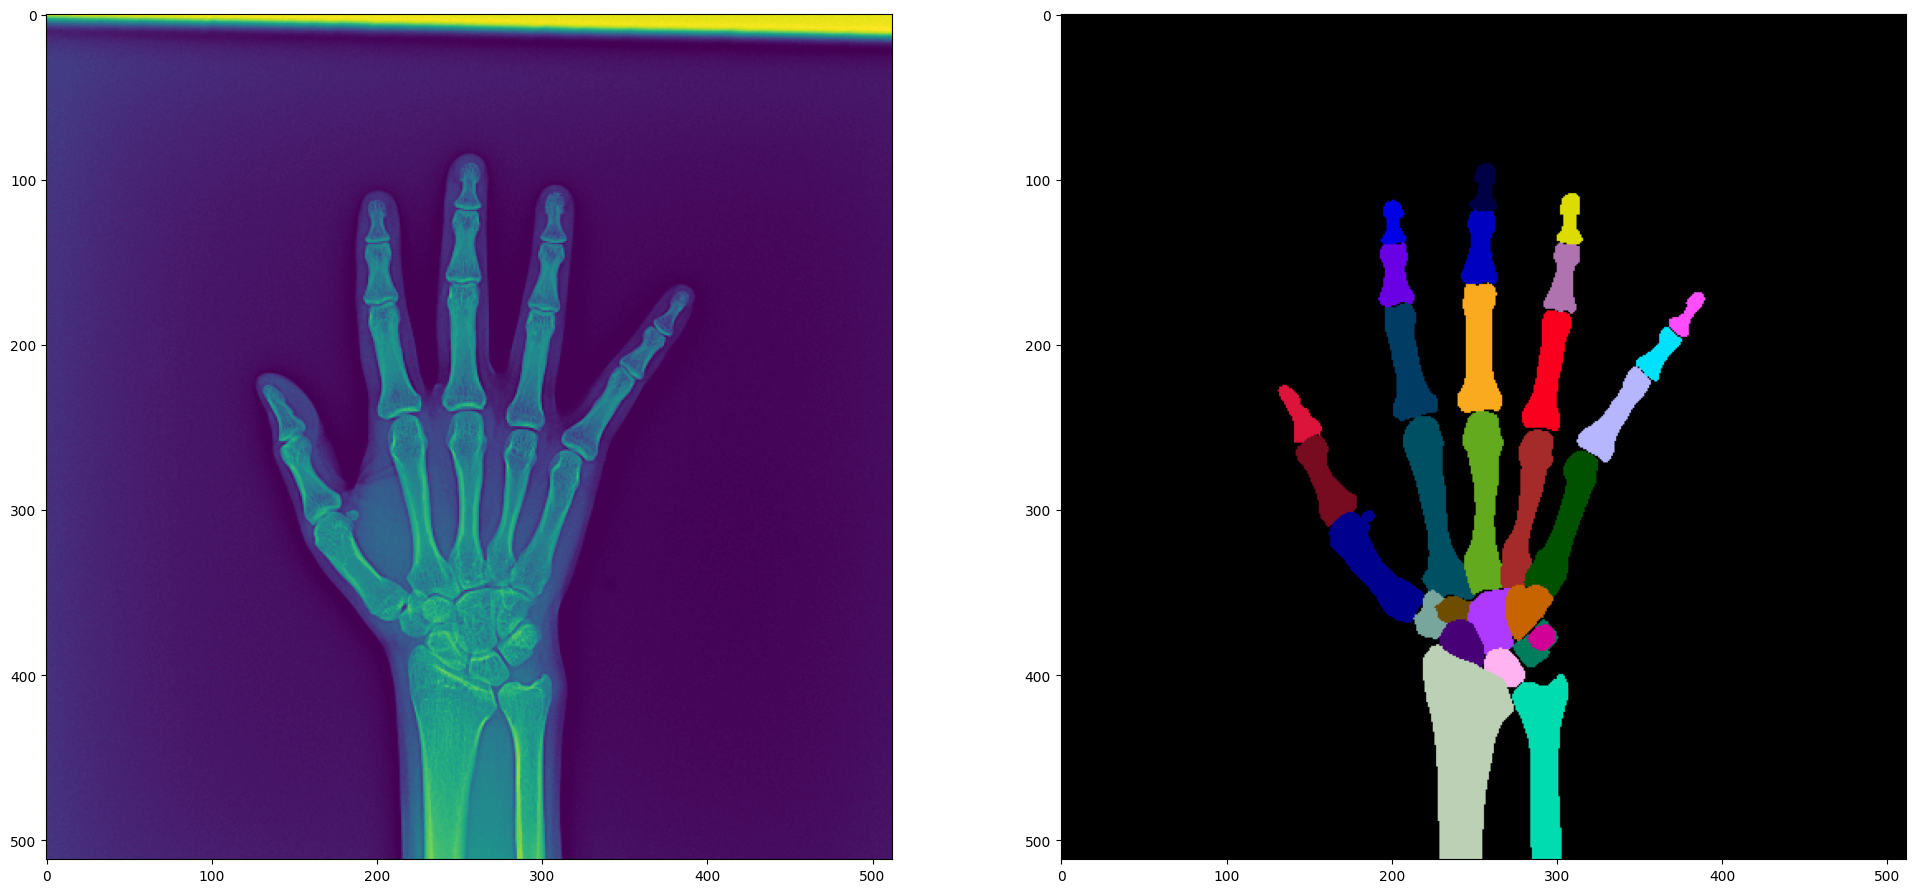

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # remove channel dimension
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [230]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

# Define Functions for Training

In [231]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [232]:
def save_model(model, file_name='fcn_resnet50_best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [233]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [234]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)['out']
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            
            dice = dice_coef(outputs, masks)
            dices.append(dice)
                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    avg_dice = torch.mean(dices_per_class).item()
    
    return avg_dice

In [235]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    
    n_class = len(CLASSES)
    best_dice = 0.
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()
            model = model.cuda()
            
            # inference
            outputs = model(images)['out']
            
            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

# Training

In [236]:
model = models.segmentation.fcn_resnet50(pretrained=True)

# output class를 data set에 맞도록 수정
model.classifier[4] = nn.Conv2d(512, len(CLASSES), kernel_size=1)

In [237]:
# Loss function 정의
criterion = nn.BCEWithLogitsLoss()

# Optimizer 정의
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [238]:
set_seed()

In [ ]:
train(model, train_loader, valid_loader, criterion, optimizer)

# Inference

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [2]:
# SAVED_DIR = '/opt/ml/input/code/pytorch/trained_model/2023-06-14-03-13-17'
# model = torch.load(os.path.join(SAVED_DIR, "best.pt"))

In [3]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/input/data/test"

In [4]:
IMAGE_ROOT = "/opt/ml/input/data/test"

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [5]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [7]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [8]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)['out']
            
            # restore original size
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [9]:
tf = A.Resize(512, 512)

In [10]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [11]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [12]:
rles, filename_and_class = test(model, test_loader)

# Result Visualization

In [13]:
filename_and_class[0]

'finger-1_DCM/ID040/image1661319116107.png'

In [14]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [15]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

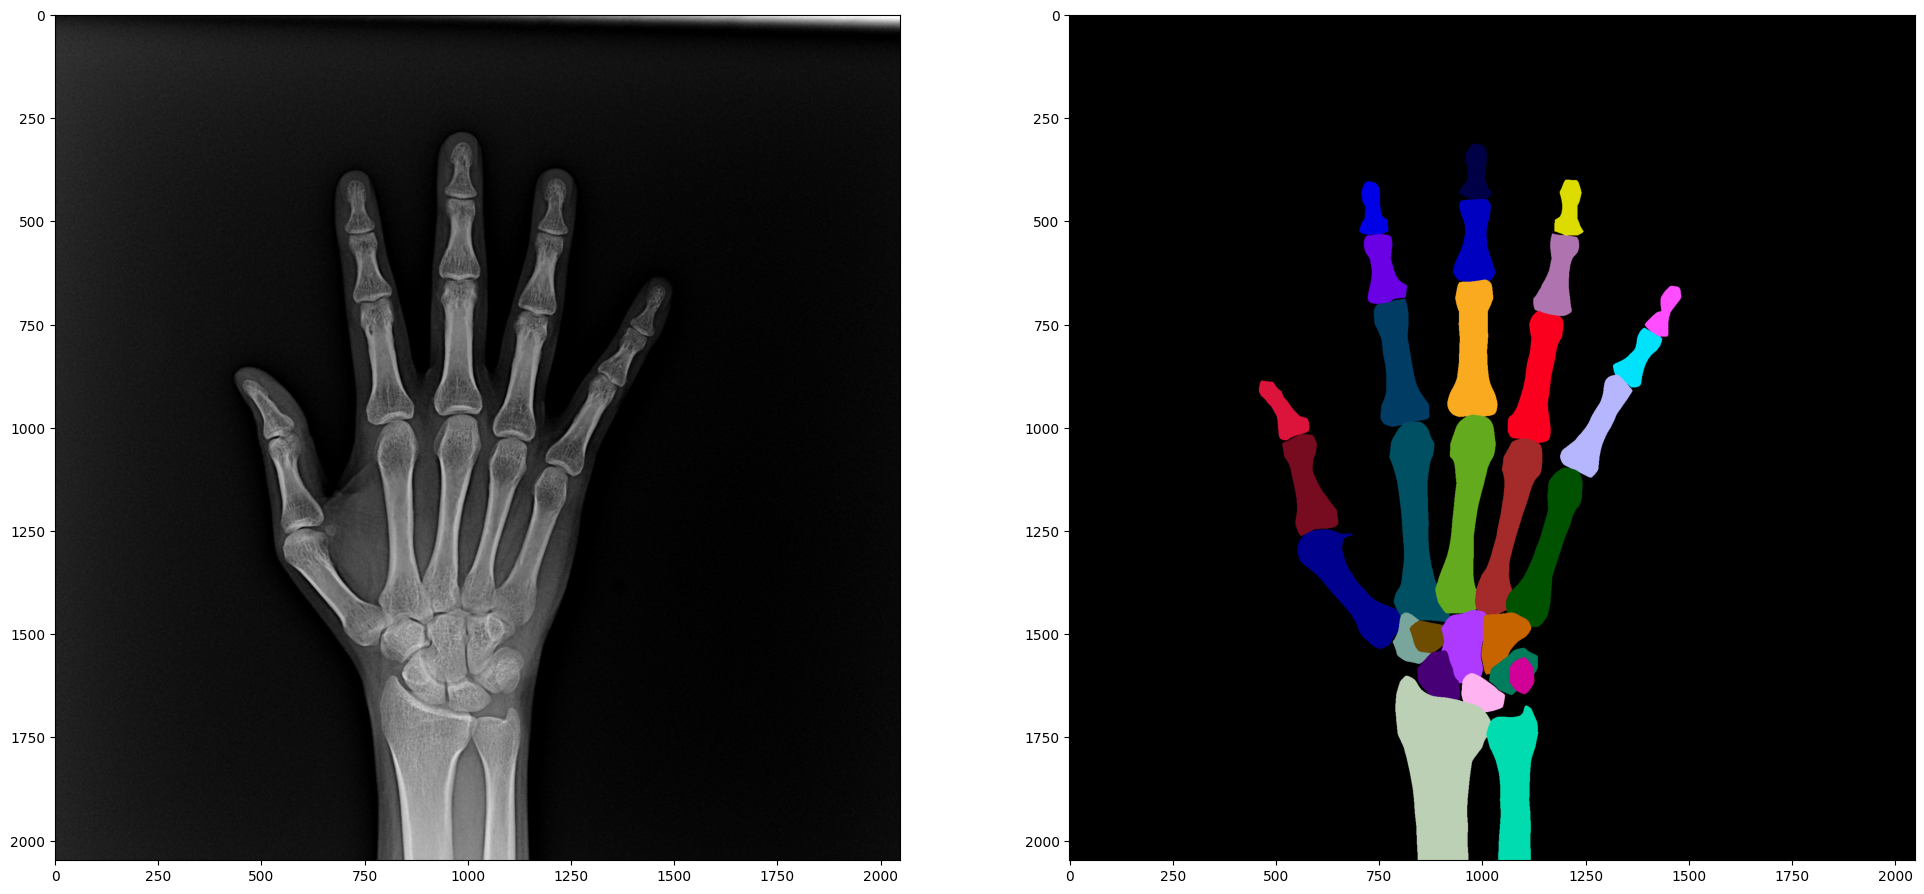

In [16]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
] 

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [17]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [18]:
image_name = [os.path.basename(f) for f in filename]

In [19]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [20]:
df.head(30)

image_name       class  \
0   image1661319116107.png    finger-1   
1   image1661319116107.png    finger-2   
2   image1661319116107.png    finger-3   
3   image1661319116107.png    finger-4   
4   image1661319116107.png    finger-5   
5   image1661319116107.png    finger-6   
6   image1661319116107.png    finger-7   
7   image1661319116107.png    finger-8   
8   image1661319116107.png    finger-9   
9   image1661319116107.png   finger-10   
10  image1661319116107.png   finger-11   
11  image1661319116107.png   finger-12   
12  image1661319116107.png   finger-13   
13  image1661319116107.png   finger-14   
14  image1661319116107.png   finger-15   
15  image1661319116107.png   finger-16   
16  image1661319116107.png   finger-17   
17  image1661319116107.png   finger-18   
18  image1661319116107.png   finger-19   
19  image1661319116107.png   Trapezium   
20  image1661319116107.png   Trapezoid   
21  image1661319116107.png    Capitate   
22  image1661319116107.png      Hamate   
23  image1661319116107.png    Scaphoid   
24  image1661319116107.png      Lunate   
25  image1661319116107.png  Triquetrum   
26  image1661319116107.png    Pisiform   
27  image1661319116107.png      Radius   
28  image1661319116107.png        Ulna   
29  image1661319145363.png    finger-1   

                                                  rle  
0   1817043 3 1819090 10 1821137 20 1823185 30 182...  
1   2081330 4 2083375 18 2085421 29 2087467 36 208...  
2   2554478 2 2556513 22 2558547 41 2560591 49 256...  
3   830161 10 832207 17 834254 21 836302 24 838349...  
4   1092331 17 1094370 34 1096410 45 1098451 54 11...  
5   1411882 5 1413925 11 1415968 16 1418009 23 142...  
6   2022203 24 2024242 35 2026287 40 2028334 43 20...  
7   642003 3 644049 12 646096 18 648143 23 650190 ...  
8   918495 20 920517 48 922555 59 924599 64 926646...  
9   1317867 9 1319909 17 1321951 25 1323992 33 132...  
10  1987534 10 1989579 21 1991624 30 1993669 38 19...  
11  822451 12 824498 28 826545 31 828593 31 830640...  
12  1088659 2 1090706 6 1092754 10 1094802 18 1096...  
13  1473647 6 1475694 9 1477740 13 1479787 17 1481...  
14  2104395 10 2106437 20 2108481 28 2110525 35 21...  
15  1349042 7 1351087 17 1353134 22 1355181 24 135...  
16  1557871 5 1559918 8 1561965 11 1564012 13 1566...  
17  1789227 6 1791270 14 1793314 19 1795360 22 179...  
18  2249902 11 2251948 18 2253994 24 2256040 29 22...  
19  2968365 8 2970412 12 2972458 16 2974505 19 297...  
20  3007314 2 3009358 12 3011405 18 3013451 25 301...  
21  2954195 1 2956239 14 2958284 23 2960330 30 296...  
22  2966575 2 2968617 13 2970658 22 2972697 34 297...  
23  3154830 1 3156872 9 3158913 18 3160954 25 3162...  
24  3267535 1 3269580 9 3271626 14 3273672 18 3275...  
25  3142732 4 3144774 11 3146817 18 3148861 23 315...  
26  3189838 2 3191882 8 3193927 13 3195972 17 3198...  
27  3281711 7 3283758 11 3285805 14 3287852 17 328...  
28  3427411 1 3429458 4 3431505 7 3433552 10 34356...  
29  1639890 3 1641936 10 1643982 16 1646029 19 164...

In [21]:
df.to_csv(os.path.join(SAVED_DIR, "output.csv"), index=False)